# Peer Review Assignment Week 3

### View on NB Viewer: https://nbviewer.jupyter.org/github/prtlobo/Coursera_Capstone/blob/f7a532e7cfb1452c4ebfed443d2d71aa27c25a28/Peer%20Review%20Assignment%3AW3.ipynb

#### By Rafael Lobo

## Part 1: Collecting PostalCode, Borough, and Neighborhood

In [2]:
import numpy as np 
import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth',None)
import json
#!pip install geopy
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
! pip install folium==0.5.0
import folium 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

     |████████████████████████████████| 79 kB 6.2 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=5df438907bee6c305e9dc088c63df050009004a91b43580733df9cb1acb35ab0
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium


In [3]:
#Extract table from wikipedia
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
site=requests.get(url).text
postal=pd.read_html(site,flavor='bs4')
df_postal=postal[0]
df_postal.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [147]:
df_postal.shape

(180, 3)

In [4]:
#checking if bourough and neigbourhood have equal number of Not assigned
print(df_postal['Neighbourhood'].str.contains('Not assigned').sum())
print(df_postal['Borough'].str.contains('Not assigned').sum())

77
77


In [5]:
#drop rows where Borough is not assigned
#Since neighbourhood and borough contain equal not assigned, can drop one
df_postal = df_postal[df_postal.Borough != 'Not assigned'].reset_index(drop=True)
df_postal.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [150]:
df_postal.shape

(103, 3)

In [6]:
#check if more than 1 bourough or neighbourhood belong to each postal code(checking duplciates)
df_count=df_postal.groupby('Postal Code').count()
print((df_count['Borough']>1).any())
print((df_count['Neighbourhood']>1).any())

False
False


In [7]:
#final print shape
print('There is {} rows in the dataframe'.format(df_postal.shape[0]))

There is 103 rows in the dataframe


## Part 2: Adding Geo information ( Latitude & Longitude)

In [ ]:
#The Geolocator app is unreliable so will use given csv file instead
#geolocator = Nominatim(user_agent='test')

#def LatLong(Code):
    
#    address='{}, Toronto, Ontario'.format(Code)
#    location = geolocator.geocode(address)
#    latitude = location.latitude
#    longitude = location.longitude
#    return 


In [8]:
#http://cocl.us/Geospatial_data is shortened url of https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
df_coordinates=pd.read_csv('https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv')
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
#combine postal code df with coordinates df
df_locations=pd.merge(df_postal,df_coordinates,on='Postal Code')
df_locations.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Part 3: Creating Neighbourhood Clusters

In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[43.651070,-79.347015], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_locations['Latitude'], df_locations['Longitude'], df_locations['Borough'], df_locations['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [11]:
#Setting Foursquare API information
CLIENT_ID = 'X'
CLIENT_SECRET = 'X'
ACCESS_TOKEN = 'X'
VERSION = '20180605'
LIMIT = 100

#function to get venues for each  postal code
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Postal Code Latitude', 
                  'Postal Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
toronto_venues = getNearbyVenues(names=df_locations['Postal Code'],
                                   latitudes=df_locations['Latitude'],
                                   longitudes=df_locations['Longitude']
                                  )
toronto_venues.head()

,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,M4A,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,M4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [45]:
#create one hot for each of the venue catagories then create new dataframe with normalised values
toronto_onehot=pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.insert(0,'Postal Code',toronto_venues['Postal Code'])
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped.head()

,Postal Code,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#For some reason Foursquare does not return results for these post codes
df_locations['Missing']=df_locations['Postal Code'].isin(toronto_grouped['Postal Code'])
missingpostcode=df_locations[df_locations['Missing']==False]
missingpostcode

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Missing
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,False
64,M9N,York,Weston,43.706876,-79.518188,False
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,False


In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

postal_venues_sorted = pd.DataFrame(columns=columns)
postal_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    postal_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

postal_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,Dessert Shop,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
1,M1C,Home Service,Bar,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dim Sum Restaurant
2,M1E,Mexican Restaurant,Electronics Store,Intersection,Breakfast Spot,Restaurant,Rental Car Location,Medical Center,Bank,Yoga Studio,Discount Store
3,M1G,Coffee Shop,Korean BBQ Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,M1H,Hakka Restaurant,Gas Station,Fried Chicken Joint,Bank,Bakery,Caribbean Restaurant,Athletics & Sports,Thai Restaurant,Creperie,Concert Hall


In [48]:
#finding best k number for cluster using silououette score
toronto_grouped_clustering = toronto_grouped.drop('Postal Code', 1)

sil = []
kmax = 20

for k in range(2, kmax+1):
  kmeanstest = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
  labels = kmeanstest.labels_
  sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))

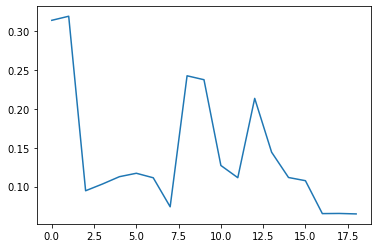

In [53]:
plt.plot(sil)
plt.show()

In [54]:
#choose k with highest silhouhette score after k=1
kbest=sil.index(max(sil[2:20]))
kmean = KMeans(n_clusters=kbest, random_state=0).fit(toronto_grouped_clustering)
print(kbest)

8


In [56]:
#Combine cluster label results with postcode data and Foursquare API data excluding missing post codes
postal_venues_kmean=postal_venues_sorted
#postal_venues_kmean.drop('Cluster Labels',1, inplace=True)
postal_venues_kmean.insert(0, 'Cluster Labels', kmean.labels_)
toronto_merged = df_locations[df_locations['Missing']==True]
toronto_merged.drop('Missing', axis=1, inplace=True)
toronto_merged = toronto_merged.join(postal_venues_kmean.set_index('Postal Code'), on='Postal Code')
toronto_merged.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Park,Food & Drink Shop,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Portuguese Restaurant,Coffee Shop,Hockey Arena,Intersection,Pizza Place,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dessert Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Theater,Café,Historic Site,Beer Store,Spa
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Clothing Store,Accessories Store,Furniture / Home Store,Boutique,Event Space,Vietnamese Restaurant,Coffee Shop,Miscellaneous Shop,Doner Restaurant,Discount Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,College Auditorium,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café


### Map with 8 Clusters

In [58]:
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kbest)
ys = [i + x + (i*x)**2 for i in range(kbest)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Thank you for your time!